In [7]:
# from google.colab import files
# files.upload()
#!unzip test1
!ls

adc.json  Cat_Dog_data.zip  sample_data


# This code is used to download data in google colab

In [ ]:
transformations = transforms.Compose([transforms.Scale(32),transforms.ToTensor()])

dset = KaggleAmazonDataset(train_data,img_path,img_ext,transformations)
train_loader = DataLoader(dset,
                          batch_size=256,
                          shuffle=True,
                          num_workers=4
                         # pin_memory=True # CUDA only
                         )

In [8]:
!unzip Cat_Dog_data


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#!unzip Cat_Dog_data


In [ ]:
#!kaggle competitions download -c Cat_Dog_data -p /content/

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# Cats and Dogs Classification (Using Convolutionnal Neural Network + Pytorch)

## To perform well on CNN,  we need to incorporate some prior knowledge about the problem

* Assumptions helps us when they are true
* They hurt us when they are not
* We want to make just the right amount of assumptions, not more than that

## In Deep Learning

* Many layers: compositionality
* Convolutions: locality + stationarity of images
* Pooling: Invariance of object class to translations

# package we need

In [14]:
import os
import sys
import cv2
import pandas as pd
import random
import torch
import torch.nn as nn
from torchvision import datasets ,models,transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim import lr_scheduler
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset

from PIL import Image


# function to count number of parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

## Load the dataset

In [15]:
# class CatDogDataset(Dataset):
#     def __init__(self, path, transform=None):
#         self.classes   = os.listdir(path)
#         self.path      = [f"{path}/{className}" for className in self.classes]
#         self.file_list = [glob.glob(f"{x}/*") for x in self.path]
#         self.transform = transform
        
#         files = []
#         for i, className in enumerate(self.classes):
#             for fileName in self.file_list[i]:
#                 files.append([i, className, fileName])
#         self.file_list = files
#         files = None
        
#     def __len__(self):
#         return len(self.file_list)

#     def __getitem__(self, idx):
#         fileName = self.file_list[idx][2]
#         classLabel = self.file_list[idx][0]
#         image = Image.open(fileName)
#         if self.transform:
#             im = self.transform(im)
#         return image.view(-1), classLabel


In [17]:
## Write data loaders for training,  and test sets
## Specify appropriate transforms, and batch_sizes
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
input_size =224*224*3
output_size = 2
# define training, valid and test data directories
data_dir = './data/dataset/'
train_dir = os.path.join(data_dir, 'train/')
#valid_dir = os.path.join(data_dir, 'valid/')
test_dir = os.path.join(data_dir, 'test/')

train_transform = transforms.Compose([transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
                                    transforms.RandomRotation(degrees=15),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.CenterCrop(size=224),
                                    transforms.ToTensor(),#])
                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                         [0.229, 0.224, 0.225])])

# valid_transforms = transforms.Compose([transforms.Resize(256),
#                                     transforms.CenterCrop(size=224),
#                                     transforms.ToTensor(),
#                                     transforms.Normalize([0.485, 0.456, 0.406],
#                                                          [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(size=(224,224)),
                                    transforms.ToTensor(),#])
                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                         [0.229, 0.224, 0.225])])


train_data = datasets.ImageFolder(train_dir, transform=train_transform)
#valid_data = datasets.ImageFolder(valid_dir, transform=valid_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)


train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    num_workers=num_workers, shuffle=True)
# valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, 
   # num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)


In [21]:
len(next(iter(test_loader)))

2

In [22]:
for batch_idx, (data, target) in enumerate(train_loader):
    print(data.size())
    break

torch.Size([20, 3, 224, 224])


# Data visualization

If we just visualise the data that we have loaded we may noticed that the image look too strenge, that is because the images we loaded are normalize.

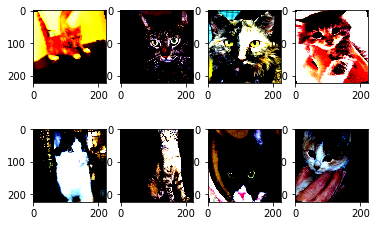

In [23]:
# show some images
plt.figure()
for i in range(8):
    plt.subplot(2, 4, i + 1)
    image, _ = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy().transpose(1,2,0).clip(0,1))

In [24]:
import torch
print(torch.__version__)

1.3.1+cpu


If we want to see our images in the original format, color,... the we need to denormalize them.
 
To do that we use the following function

In [ ]:

classes = ['cat','dog']
mean , std = torch.tensor([0.485, 0.456, 0.406]),torch.tensor([0.229, 0.224, 0.225])

def denormalize(image):
  image = transforms.Normalize(-mean/std,1/std)(image) #denormalize
  image = image.permute(1,2,0) #Changing from 3x224x224 to 224x224x3
  image = torch.clamp(image,0,1)
  return image
# helper function to un-normalize and display an image
def imshow(img):
    img = denormalize(img) 
    plt.imshow(img)

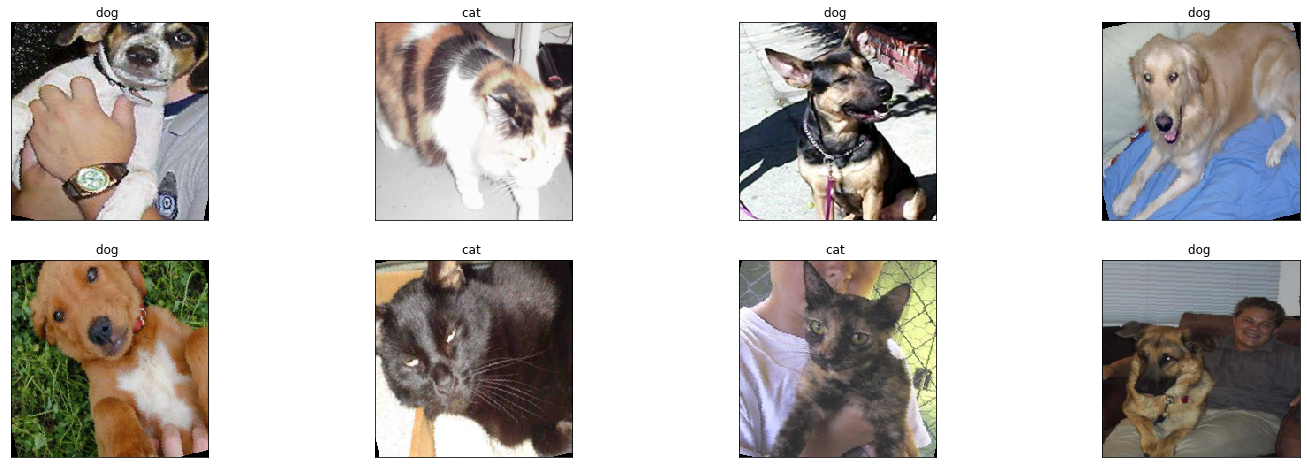

In [13]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 8))
# display 10 images
for idx in np.arange(8):
    ax = fig.add_subplot(2, 8/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title("{} ".format( classes[labels[idx]]))

# Our model :

Here we want to compare the performance of the fully connected NN and the CNN.

That's why we have to separate model

In [ ]:
class FC2Layer(nn.Module):
    def __init__(self, input_size, n_hidden, output_size):
        super(FC2Layer, self).__init__()
        self.input_size = input_size
        self.network = nn.Sequential(
            nn.Linear(input_size, n_hidden), 
            nn.ReLU(), 
            nn.Linear(n_hidden, n_hidden), 
            nn.ReLU(), 
            nn.Linear(n_hidden, output_size), 
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = x.view(-1, self.input_size)
        return self.network(x)
    
class CNN(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(CNN, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=n_feature, kernel_size=5)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.fc1 = nn.Linear(n_feature*53*53, 50)
        self.fc2 = nn.Linear(50, 2)
        
    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, self.n_feature*53*53)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

In [ ]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Train and Test functions

In [ ]:
accuracy_list = []

def train(epoch, model,perm=torch.arange(0, 50176).long()):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        #we chage the device if the GPU is available
        if  torch.cuda.is_available():
              data, target = data.cuda(), target.cuda()
        # permute pixels
#         data = data.view(-1, 224*224)
#         data = data[:, perm]
#         data = data.view(-1, 3, 224, 224)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
def test(model, perm=torch.arange(0, 50176).long()):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
          #we chage the device if the GPU is available
          if  torch.cuda.is_available():
              data, target = data.cuda(), target.cuda()
          
          # permute pixels
          data = data.view(-1, 224*224)
          data = data[:, perm]
          data = data.view(-1, 3, 224, 224)
          output = model(data)
          test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss                                                               
          pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
          correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_list.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))

# Experiment on Fully connected NN :


# Train a small fully-connected network

In [20]:
n_hidden = 6 # number of hidden units

model_fnn = FC2Layer(input_size, n_hidden, output_size).cuda()
#we change the device if the GPU is available
if  torch.cuda.is_available():
  model_fnn = model_fnn.cuda()
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_fnn)))

for epoch in range(0, 1):
    train(epoch, model_fnn)
    test(model_fnn)

Number of parameters: 903230
Train Epoch: 0 [0/22500 (0%)]	Loss: 0.709499
Train Epoch: 0 [2000/22500 (9%)]	Loss: 0.680270
Train Epoch: 0 [4000/22500 (18%)]	Loss: 0.701667
Train Epoch: 0 [6000/22500 (27%)]	Loss: 0.703140
Train Epoch: 0 [8000/22500 (36%)]	Loss: 0.723957
Train Epoch: 0 [10000/22500 (44%)]	Loss: 0.672304
Train Epoch: 0 [12000/22500 (53%)]	Loss: 0.678066
Train Epoch: 0 [14000/22500 (62%)]	Loss: 0.772037
Train Epoch: 0 [16000/22500 (71%)]	Loss: 0.652806
Train Epoch: 0 [18000/22500 (80%)]	Loss: 0.621261
Train Epoch: 0 [20000/22500 (89%)]	Loss: 0.617760
Train Epoch: 0 [22000/22500 (98%)]	Loss: 0.633389

Test set: Average loss: 0.6617, Accuracy: 1478/2500 (59%)



In [75]:
#torch.cuda.is_available()

True

In [86]:
#device

device(type='cuda', index=0)

# Experiment on CNN

# Train CNN network

In [21]:
# Training settings 
n_features =6 # number of feature maps
model_cnn = CNN(input_size, n_features, output_size)
#we change the device if the GPU is available
if  torch.cuda.is_available():
  model_cnn = model_cnn.cuda()
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 1):
    train(epoch, model_cnn)
    test(model_cnn)

Number of parameters: 844214
Train Epoch: 0 [0/22500 (0%)]	Loss: 0.697748
Train Epoch: 0 [2000/22500 (9%)]	Loss: 0.665783
Train Epoch: 0 [4000/22500 (18%)]	Loss: 0.635451
Train Epoch: 0 [6000/22500 (27%)]	Loss: 0.706747
Train Epoch: 0 [8000/22500 (36%)]	Loss: 0.744352
Train Epoch: 0 [10000/22500 (44%)]	Loss: 0.601695
Train Epoch: 0 [12000/22500 (53%)]	Loss: 0.690189
Train Epoch: 0 [14000/22500 (62%)]	Loss: 0.654046
Train Epoch: 0 [16000/22500 (71%)]	Loss: 0.580865
Train Epoch: 0 [18000/22500 (80%)]	Loss: 0.650111
Train Epoch: 0 [20000/22500 (89%)]	Loss: 0.793262
Train Epoch: 0 [22000/22500 (98%)]	Loss: 0.645401

Test set: Average loss: 0.6324, Accuracy: 1623/2500 (65%)



# The ConvNet performs better with the same number of parameters, thanks to its use of prior knowledge about images

* Use of convolution: Locality and stationarity in images
* Pooling: builds in some translation invariance

# What happens if the assumptions are no longer true?




So let's permut the pixels of our images

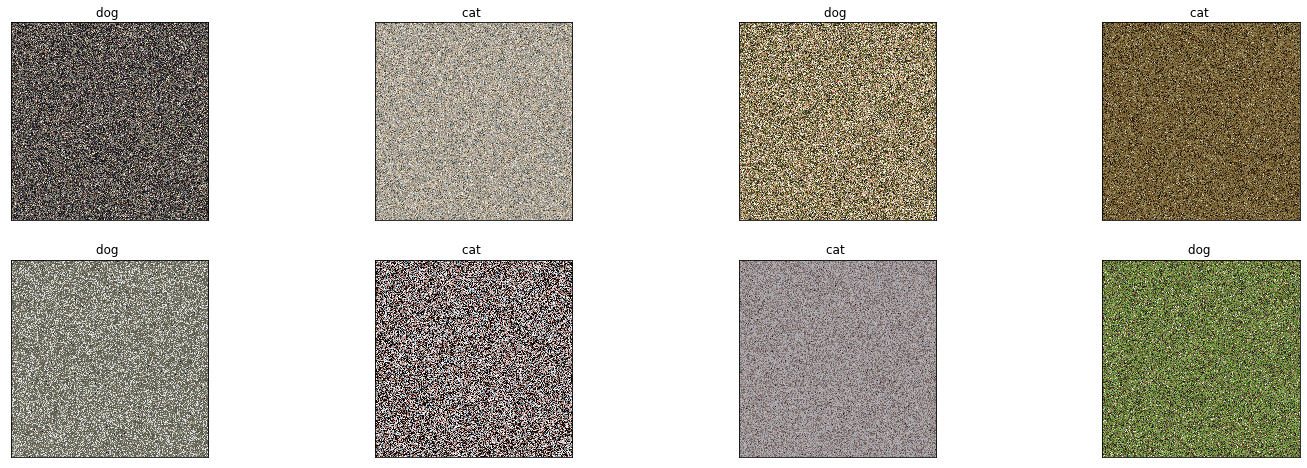

In [23]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# permute pixels
perm = torch.randperm(50176)
image_perm = images.view(-1, 224*224).clone()
image_perm = image_perm[:, perm]
image_perm = image_perm.view(-1, 3, 224, 224)
# plot the image  in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 8))
# display 10 images
for idx in np.arange(8):
    ax = fig.add_subplot(2, 8/2, idx+1, xticks=[], yticks=[])
    imshow(image_perm[idx])
    ax.set_title("{} ".format( classes[labels[idx]]))

# Fully-Connected with Permuted Pixels

In [25]:
n_hidden = 6    # number of hidden units

model_fnn = FC2Layer(input_size, n_hidden, output_size)
#we change the device if the GPU is available
if  torch.cuda.is_available():
  model_fnn = model_fnn.cuda()
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_fnn)))

for epoch in range(0, 1):
    train(epoch, model_fnn, perm)
    test(model_fnn, perm)

Number of parameters: 903230
Train Epoch: 0 [0/22500 (0%)]	Loss: 0.703761
Train Epoch: 0 [2000/22500 (9%)]	Loss: 0.630389
Train Epoch: 0 [4000/22500 (18%)]	Loss: 0.655909
Train Epoch: 0 [6000/22500 (27%)]	Loss: 0.711992
Train Epoch: 0 [8000/22500 (36%)]	Loss: 0.630860
Train Epoch: 0 [10000/22500 (44%)]	Loss: 0.713312
Train Epoch: 0 [12000/22500 (53%)]	Loss: 0.636317
Train Epoch: 0 [14000/22500 (62%)]	Loss: 0.621614
Train Epoch: 0 [16000/22500 (71%)]	Loss: 0.630347
Train Epoch: 0 [18000/22500 (80%)]	Loss: 0.603706
Train Epoch: 0 [20000/22500 (89%)]	Loss: 0.664196
Train Epoch: 0 [22000/22500 (98%)]	Loss: 0.645938

Test set: Average loss: 0.6927, Accuracy: 1323/2500 (53%)



# ConvNet with permuted pixels

In [26]:
# Training settings 
n_features =6 # number of feature maps
model_cnn = CNN(input_size, n_features, output_size)
#we chage the device if the GPU is available
if  torch.cuda.is_available():
  model_cnn = model_cnn.cuda()
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 1):
    train(epoch, model_cnn, perm)
    test(model_cnn, perm)

Number of parameters: 844214
Train Epoch: 0 [0/22500 (0%)]	Loss: 0.675200
Train Epoch: 0 [2000/22500 (9%)]	Loss: 0.682093
Train Epoch: 0 [4000/22500 (18%)]	Loss: 0.672615
Train Epoch: 0 [6000/22500 (27%)]	Loss: 0.611274
Train Epoch: 0 [8000/22500 (36%)]	Loss: 0.697527
Train Epoch: 0 [10000/22500 (44%)]	Loss: 0.731235
Train Epoch: 0 [12000/22500 (53%)]	Loss: 0.635272
Train Epoch: 0 [14000/22500 (62%)]	Loss: 0.655396
Train Epoch: 0 [16000/22500 (71%)]	Loss: 0.624252
Train Epoch: 0 [18000/22500 (80%)]	Loss: 0.681616
Train Epoch: 0 [20000/22500 (89%)]	Loss: 0.586551
Train Epoch: 0 [22000/22500 (98%)]	Loss: 0.549952

Test set: Average loss: 0.7454, Accuracy: 1237/2500 (49%)



# The ConvNet's performance drops when we permute the pixels, but the Fully-Connected Network's performance stays the same

* ConvNet makes the assumption that pixels lie on a grid and are stationary/local
* It loses performance when this assumption is wrong
* The fully-connected network does not make this assumption
* It does less well when it is true, since it doesn't take advantage of this prior knowledge
* But it doesn't suffer when the assumption is wrong

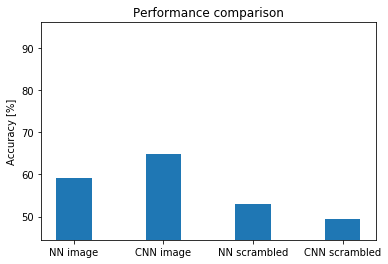

In [31]:
plt.bar(('NN image', 'CNN image','NN scrambled',
         'CNN scrambled'),
        accuracy_list, width=0.4)
plt.ylim((min(accuracy_list)-5, 96))
plt.ylabel('Accuracy [%]')
for tick in plt.gca().xaxis.get_major_ticks():
    tick.label.set_fontsize(10)
plt.title('Performance comparison');

##  particular way to load data without using pytorch 


In [ ]:
input_size  = 100*100  # images are 28x28 pixels
output_size = 2      # there are 10 classes

image_path = './Cat_Dog_data/train/cat'
filenames = os.listdir(image_path)
categories = []
dog = []
cat = []
for filename in filenames:
    file_category = filename.split(".")[0]
    
    if file_category == "dog":
        categories.append(0)
        dog.append(filename)
    else : 
        categories.append(1)
        cat.append(filename)
    
df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [39]:
df.head(3)

,filename,category
0,cat.1097.jpg,1
1,cat.10853.jpg,1
2,cat.4388.jpg,1
